In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [28]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

#dataset = pd.read_csv(datapath+'25-3-25-fillFac.csv')
dataset = pd.read_csv(datapath+'4-4-25-thetaSTD.csv')
# do 4-4

#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [29]:
dataset

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,2BRfillnear,thetaSTDnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,...,thetaSTDfar,3BRfill,MEGNO,MEGNOstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable
0,0.060234,0.029447,0.001995,0.498040,8.652930,0.967994,0.504063,0.002900,0.000816,NaN,...,1.815056,1.917395,1.998619,0.003190,28431.355594,1.0,0000000.bin,1.545872e+06,3.063700e+06,False
1,0.080547,0.016559,0.000112,0.452015,25.825316,1.559636,0.240504,0.006736,0.001621,0.008674,...,1.772353,0.407998,2.001688,0.004966,3904.311701,1.0,0000001.bin,9.990000e+08,9.990000e+08,True
2,0.129660,0.028844,0.003181,1.001973,1.051448,0.105776,1.001981,0.001402,0.003742,0.010415,...,1.817621,0.418203,1.995051,0.003312,70073.695993,1.0,0000002.bin,9.990000e+08,9.990000e+08,True
3,0.406112,0.036478,0.002390,0.321071,0.040700,1.721175,0.427768,0.036219,0.008587,0.012958,...,1.725890,0.122730,2.002493,0.000335,18313.684674,1.0,0000003.bin,2.287671e+06,8.392234e+06,False
4,0.059897,0.028009,0.001623,0.341814,3.462553,0.446636,0.257596,0.053197,0.001287,0.034789,...,1.786143,2.369149,2.029737,0.013224,4110.203941,1.0,0000004.bin,9.668931e+05,3.380350e+05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102492,0.089252,NaN,NaN,NaN,NaN,NaN,0.310694,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,23579.372334,0.0,9044761.bin,6.303165e+04,6.470086e+04,False
102493,0.082222,0.039388,0.006138,0.680735,3.218405,0.240267,0.664222,0.031006,0.001013,NaN,...,1.768091,3.802285,1.999428,0.004978,4127.353879,1.0,9045377.bin,6.990387e+05,8.267916e+05,False
102494,0.131799,0.022057,0.000146,0.840640,2.216943,0.130695,0.366664,0.060791,0.016575,0.005149,...,1.892131,0.543637,2.079857,0.076478,1130.303709,1.0,9045380.bin,1.193822e+07,3.363291e+07,False
102495,0.209454,0.036889,0.005252,1.497917,7.956804,0.479853,0.395073,0.102246,0.022792,0.029719,...,1.832402,0.118894,1.875273,0.066749,4234.297102,1.0,9045382.bin,2.064407e+08,4.316851e+07,False


In [30]:
import matplotlib as mpl

In [31]:
data = dataset

In [32]:
data.columns

Index(['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       '2BRfillnear', 'thetaSTDnear', 'EMcrossfar', 'EMfracstdfar', 'EPstdfar',
       'MMRstrengthfar', '2BRfillfar', 'thetaSTDfar', '3BRfill', 'MEGNO',
       'MEGNOstd', 'Tsec', 'InitialStable', 'runstring', 'instability_time',
       'shadow_instability_time', 'Stable'],
      dtype='object')

In [33]:
data[['thetaSTDnear','thetaSTDfar']].describe()

,thetaSTDnear,thetaSTDfar
count,95951.000000,95951.000000
mean,1.202043,1.672703
std,0.677130,0.404391
min,0.011036,0.014065
25%,0.500962,1.700152
50%,1.405325,1.808397
75%,1.808181,1.844308
max,2.978812,2.939410


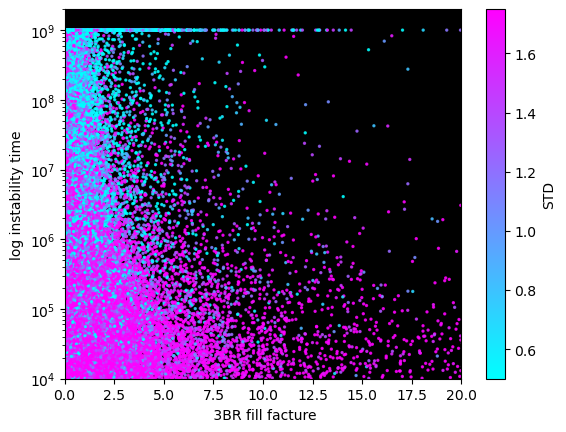

In [34]:
fig, ax = plt.subplots()
vmi = 0.5
vma = 1.75
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='STD')
ax.scatter((data['3BRfill']),(data['instability_time']), 
           s=2, c=((data['thetaSTDnear'])), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

ax.set_ylim([1e4,2e9])
ax.set_xlim([0,20])

ax.set_xlabel(" 3BR fill facture")
ax.set_ylabel("log instability time")
ax.set_yscale('log')
#cbar.set_label('close body conjunction angle std')
ax.set_facecolor("black")


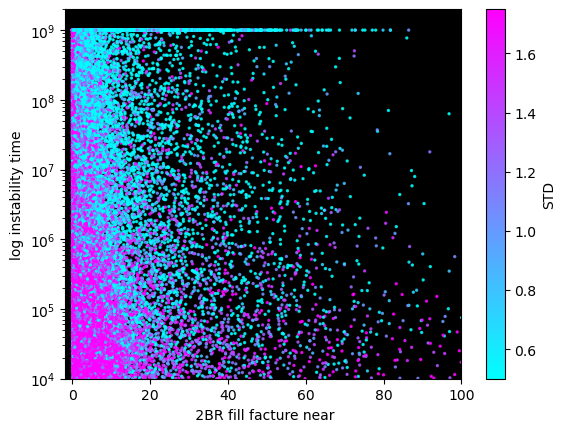

In [35]:
fig, ax = plt.subplots()
vmi = 0.5
vma = 1.75
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='STD')
ax.scatter((data['2BRfillnear']),(data['instability_time']), 
           s=2, c=((data['thetaSTDnear'])), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

ax.set_ylim([1e4,2e9])
ax.set_xlim([-2,100])

ax.set_xlabel(" 2BR fill facture near")
ax.set_ylabel("log instability time")
ax.set_yscale('log')
#cbar.set_label('close body conjunction angle std')
ax.set_facecolor("black")

In [36]:
from mpl_toolkits.mplot3d import Axes3D

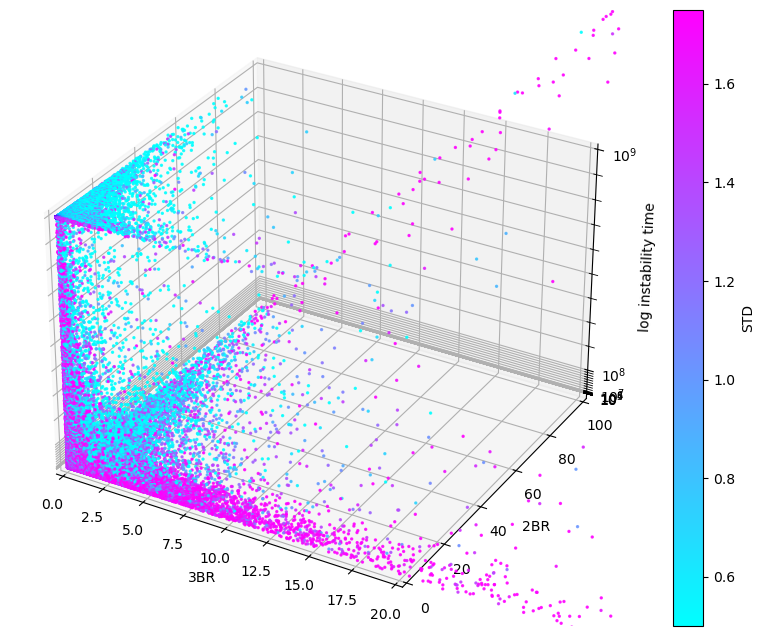

In [37]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

vmi = 0.5
vma = 1.75
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='STD')
ax.scatter((data['3BRfill']),data['2BRfillnear'],data['instability_time'],
           s=2, c=((data['thetaSTDnear'])), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

ax.set_zlim([1e4,1e9])
ax.set_xlim([0,20])
ax.set_ylim([0,100])

ax.set_xlabel("3BR")
ax.set_ylabel('2BR')
ax.set_zlabel("log instability time")
ax.set_zscale('log')
# #cbar.set_label('close body conjunction angle std')
# ax.set_facecolor("black")


Text(0.5, 0, 'theta STD')

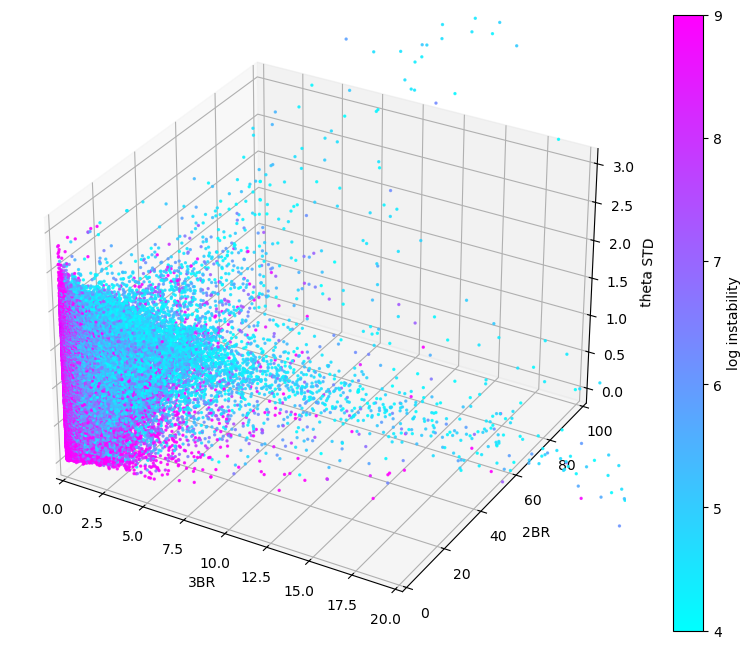

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')

vmi = 4
vma = 9
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='log instability')
ax.scatter((data['3BRfill']),data['2BRfillnear'],data['thetaSTDnear'],
           s=2, c=(np.log10(data['instability_time'])), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

ax.set_xlim([0,20])
ax.set_ylim([0,100])

ax.set_xlabel("3BR")
ax.set_ylabel('2BR')
ax.set_zlabel("theta STD")

In [39]:
drop = dataset
drop = drop[drop['3BRfill'] > 2]
drop = drop[drop['2BRfillnear'] > 2]
drop = drop[drop['thetaSTDnear'] > 1]
drop = drop[drop['thetaSTDfar'] > 1]

In [40]:
drop['Stable'].describe()

count      4979
unique        2
top       False
freq       4859
Name: Stable, dtype: object

In [41]:
drop[drop['Stable']==True].describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,2BRfillnear,thetaSTDnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,2BRfillfar,thetaSTDfar,3BRfill,MEGNO,MEGNOstd,Tsec,InitialStable,instability_time,shadow_instability_time
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,59.000000,71.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.0,1.200000e+02,1.200000e+02
mean,0.059043,0.021336,0.001237,0.287296,8.210767,1.341479,0.527543,0.012850,0.001155,0.023962,0.026146,1.831196,4.906445,2.000409,0.005654,12009.219511,1.0,9.999250e+08,9.964500e+08
std,0.020955,0.011123,0.002511,0.132663,9.809396,0.218018,0.201740,0.011261,0.001622,0.025610,0.023836,0.128960,3.323318,0.030773,0.012595,10251.569724,0.0,2.644957e+05,3.815221e+07
min,0.021367,0.007435,0.000023,0.076230,2.065707,1.005102,0.137984,0.000353,0.000008,0.001593,0.002917,1.459327,2.007284,1.890564,0.000027,1512.805583,1.0,9.990000e+08,5.820053e+08
25%,0.043560,0.011877,0.000116,0.180761,3.249969,1.155905,0.363661,0.004081,0.000198,0.006045,0.010489,1.782300,2.527071,1.996664,0.000482,4099.346526,1.0,1.000000e+09,1.000000e+09
50%,0.055476,0.019915,0.000386,0.262805,4.321548,1.353467,0.503992,0.009700,0.000565,0.014372,0.016343,1.814629,3.680946,1.999576,0.001313,7724.258998,1.0,1.000000e+09,1.000000e+09
75%,0.073213,0.026008,0.001381,0.361536,8.021248,1.478264,0.709810,0.019008,0.001262,0.031100,0.032955,1.842074,5.608476,2.001130,0.004419,18413.622185,1.0,1.000000e+09,1.000000e+09
max,0.132798,0.063762,0.020514,0.739238,60.840649,2.013589,0.942496,0.050204,0.008775,0.112220,0.109473,2.773806,19.952054,2.240171,0.083661,49321.464983,1.0,1.000000e+09,1.000000e+09


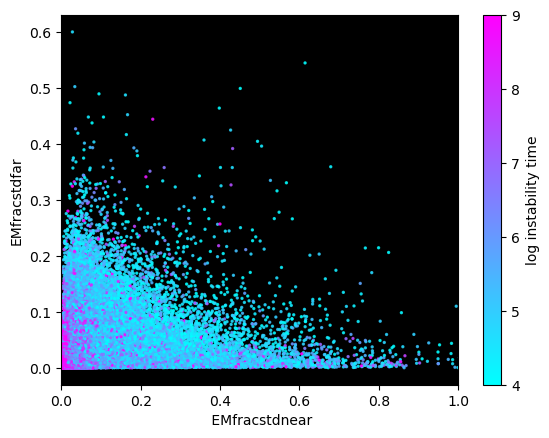

In [42]:
fig, ax = plt.subplots()
vmi = 4
vma = 9
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='log instability time')
ax.scatter((data['EMfracstdnear']),(data['EMfracstdfar']), 
           s=2, c=np.log10(data['instability_time']), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

# ax.set_ylim([-2,100])
ax.set_xlim([0,1])

ax.set_xlabel(" EMfracstdnear")
ax.set_ylabel("EMfracstdfar")
#ax.set_yscale('log')
#cbar.set_label('close body conjunction angle std')
ax.set_facecolor("black")

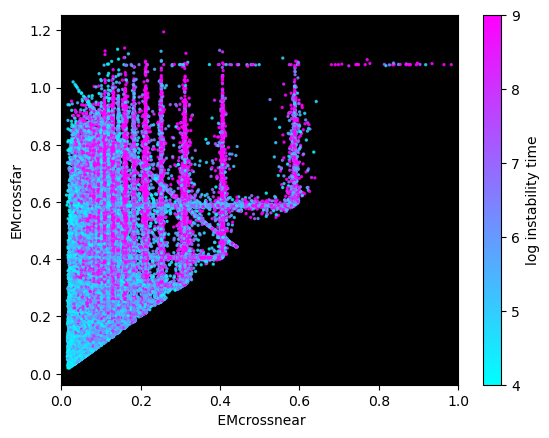

In [43]:
fig, ax = plt.subplots()
vmi = 4
vma = 9
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='log instability time')
ax.scatter((data['EMcrossnear']),(data['EMcrossfar']), 
           s=2, c=np.log10(data['instability_time']), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

# ax.set_ylim([-2,100])
ax.set_xlim([0,1])

ax.set_xlabel(" EMcrossnear")
ax.set_ylabel("EMcrossfar")
#ax.set_yscale('log')
#cbar.set_label('close body conjunction angle std')
ax.set_facecolor("black")

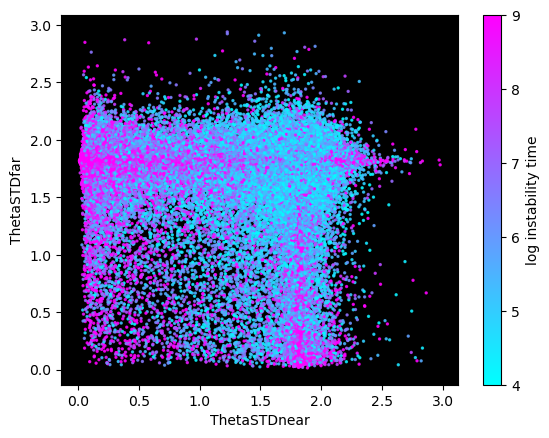

In [44]:
fig, ax = plt.subplots()
vmi = 4
vma = 9
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmi, vma), cmap='cool'),
             ax=ax, orientation='vertical', label='log instability time')
ax.scatter(data['thetaSTDnear'],data['thetaSTDfar'], 
           s=2, c=np.log10(data['instability_time']), cmap="cool",
           vmin=vmi,vmax=vma,alpha=.8)

# ax.set_ylim([-2,100])
#ax.set_xlim([0,1])

ax.set_xlabel("ThetaSTDnear")
ax.set_ylabel("ThetaSTDfar")
#ax.set_yscale('log')
#cbar.set_label('close body conjunction angle std')
ax.set_facecolor("black")

In [20]:
drop = dataset
drop = drop[drop['3BRfill'] > 2]
drop = drop[drop['2BRfillnear'] > 2]
drop = drop[drop['thetaSTDnear'] > 1]
#drop = drop[drop['thetaSTDfar'] > 1]
#drop = drop[drop['EMcrossnear'] < 0.1]
#drop = drop[drop['EMcrossfar'] < 0.2]



In [21]:
drop['Stable'].describe()

count      5516
unique        2
top       False
freq       5362
Name: Stable, dtype: object

In [22]:
drop[drop['Stable']==True].describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,2BRfillnear,thetaSTDnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,2BRfillfar,thetaSTDfar,3BRfill,MEGNO,MEGNOstd,Tsec,InitialStable,instability_time,shadow_instability_time
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,81.000000,94.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.0,1.540000e+02,1.540000e+02
mean,0.059098,0.021066,0.001443,0.323179,8.674723,1.429095,0.522204,0.012790,0.001217,0.022819,0.027118,1.787354,5.054469,1.999636,0.004951,12182.215376,1.0,9.999351e+08,9.972273e+08
std,0.021824,0.011411,0.002850,0.167139,11.071646,0.225214,0.207558,0.010780,0.001652,0.025953,0.025504,0.137335,3.491292,0.027459,0.011295,10761.206450,0.0,2.472152e+05,3.367906e+07
min,0.021367,0.006213,0.000023,0.076230,2.023032,1.002110,0.137984,0.000353,0.000008,0.001149,0.002485,0.637373,2.007284,1.890564,0.000015,1512.805583,1.0,9.990000e+08,5.820053e+08
25%,0.043162,0.011856,0.000125,0.205266,3.241426,1.252355,0.357975,0.004179,0.000202,0.005175,0.010294,1.770705,2.608068,1.996673,0.000342,4339.911201,1.0,1.000000e+09,1.000000e+09
50%,0.055300,0.019281,0.000413,0.294197,4.550010,1.461585,0.483076,0.010451,0.000597,0.011536,0.016149,1.807952,3.824200,1.999542,0.001234,7884.366990,1.0,1.000000e+09,1.000000e+09
75%,0.073316,0.025856,0.001542,0.415266,8.324335,1.591892,0.705997,0.019176,0.001464,0.031026,0.037936,1.826759,5.936780,2.000666,0.004303,17756.906750,1.0,1.000000e+09,1.000000e+09
max,0.132798,0.063762,0.020514,1.017338,72.663886,1.966367,0.974581,0.050204,0.008775,0.112220,0.109473,2.451446,20.467315,2.240171,0.083661,61227.290027,1.0,1.000000e+09,1.000000e+09


In [23]:
drop[drop['Stable']==True]

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,2BRfillnear,thetaSTDnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,...,thetaSTDfar,3BRfill,MEGNO,MEGNOstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable
692,0.039129,0.012182,0.000925,0.128262,2.345944,1.633345,0.224636,0.011523,0.000474,0.011536,...,1.847859,9.878719,1.983182,0.003052,5759.947360,1.0,0000695.bin,1.000000e+09,1.000000e+09,True
1286,0.035977,0.009362,0.000401,0.304331,40.189477,1.511015,0.238612,0.016491,0.001159,0.004728,...,1.834122,4.311897,1.999642,0.000690,12484.346451,1.0,0001289.bin,9.990000e+08,9.990000e+08,True
2121,0.036884,0.014599,0.001330,0.162973,3.749471,1.719592,0.357202,0.001987,0.000263,NaN,...,1.808824,7.115635,2.000623,0.000404,24319.594421,1.0,0002125.bin,9.990000e+08,5.820053e+08,True
2373,0.060151,0.028420,0.000029,0.287019,3.548566,1.370316,0.358776,0.026536,0.001180,NaN,...,2.005193,3.038148,2.014006,0.009626,2813.485262,1.0,0002377.bin,1.000000e+09,1.000000e+09,True
2928,0.047315,0.020853,0.000074,0.286249,6.613796,1.463209,0.558017,0.013623,0.000216,0.031344,...,1.691881,6.855673,2.001717,0.001214,3804.223824,1.0,0002933.bin,9.990000e+08,9.990000e+08,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100502,0.047217,0.016406,0.002955,0.185889,2.131899,1.591377,0.264171,0.001557,0.000546,0.002889,...,1.773464,2.007284,2.240171,0.083661,33123.230816,1.0,8536038.bin,1.000000e+09,1.000000e+09,True
100655,0.081973,0.024793,0.000186,0.416432,3.287328,1.029317,0.306160,0.031011,0.001991,0.112220,...,1.690217,3.394739,2.008027,0.004440,2251.483388,1.0,8537352.bin,1.000000e+09,1.000000e+09,True
101004,0.094515,0.022755,0.000479,0.357781,2.289641,1.449672,0.731994,0.022052,0.000844,NaN,...,1.826578,3.049213,2.000949,0.000710,2385.967071,1.0,8541052.bin,1.000000e+09,1.000000e+09,True
101060,0.092889,0.027873,0.000852,0.557702,13.948096,1.548979,0.662608,0.016386,0.003680,NaN,...,1.632302,3.756827,1.999506,0.000066,4110.525982,1.0,8541669.bin,1.000000e+09,1.000000e+09,True


In [24]:
drop['Stable'].sum() / drop.shape[0]

0.027918781725888325

low std of fracstdnear and far

In [25]:
keep = dataset
keep = keep[keep['3BRfill'] < 0.5]
keep = keep[keep['2BRfillnear'] < 0.5]
keep = keep[keep['thetaSTDnear'] < 0.5]




In [26]:
keep.describe()

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,2BRfillnear,thetaSTDnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,2BRfillfar,thetaSTDfar,3BRfill,MEGNO,MEGNOstd,Tsec,InitialStable,instability_time,shadow_instability_time
count,5691.000000,5691.000000,5691.000000,5689.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,4044.000000,4507.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.000000,5691.0,5.691000e+03,5.691000e+03
mean,0.221030,0.026447,0.003801,1.943812,0.211953,0.254936,0.429822,0.026805,0.005046,0.059710,0.155862,1.785034,0.143127,3.329095,0.389307,33474.721064,1.0,7.688652e+08,7.750349e+08
std,0.091443,0.020278,0.006694,2.846903,0.138325,0.126284,0.189316,0.029196,0.006815,0.174699,0.389514,0.164030,0.113791,9.791216,2.708296,28451.855958,0.0,4.007319e+08,3.992004e+08
min,0.041290,0.001398,0.000006,0.014233,0.002245,0.017477,0.066264,0.000265,0.000005,0.000225,0.000481,0.147065,0.004011,0.605630,0.000005,2403.576046,1.0,1.342599e+04,0.000000e+00
25%,0.160132,0.012466,0.000464,0.509616,0.092282,0.148344,0.281364,0.007004,0.000790,0.008826,0.021195,1.797633,0.055116,1.986707,0.001502,13235.711438,1.0,6.604423e+08,9.137797e+08
50%,0.211644,0.020672,0.001282,1.065572,0.188300,0.245090,0.407975,0.016400,0.002439,0.020117,0.056351,1.812008,0.108509,1.998833,0.006157,24887.358142,1.0,1.000000e+09,1.000000e+09
75%,0.310423,0.034505,0.004001,2.177000,0.320732,0.357793,0.544906,0.036012,0.006487,0.049507,0.153180,1.819476,0.200314,2.005503,0.029543,44415.610239,1.0,1.000000e+09,1.000000e+09
max,0.478333,0.232927,0.087175,42.355564,0.499971,0.499896,1.086388,0.343542,0.067009,3.420697,12.954579,2.384732,0.499857,223.649798,66.483829,226201.561145,1.0,1.000000e+09,1.000000e+09


In [27]:
keep['Stable'].describe()

count     5691
unique       2
top       True
freq      4177
Name: Stable, dtype: object